In [1]:
import os
import pandas as pd
from konlpy.tag import Okt
from gensim.models import Word2Vec, FastText
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import joblib

import collections
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [2]:
train_data_path ="~/aiffel/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [3]:
print(len(train_data))
train_data = train_data.drop_duplicates('conversation')
len(train_data)

3950


3846

In [4]:
train_data[train_data['conversation'].isnull()]

,idx,class,conversation


In [5]:
train_data[train_data['class'].isnull()]

,idx,class,conversation


In [6]:
train_data['class'].count()

3846

In [7]:
del train_data['idx']
train_data.reset_index(drop=True)

,class,conversation
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...
3841,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3842,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3843,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3844,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...


In [8]:
stop_word_list = ["!","\"","$","%","&","'","(",")","*","+",",","-",".","...","0","1","2","3","4","5","6","7","8","9",";","<","=",">","?","@","\\","^","_","`","|","~","·","—","——","‘","’","“","”","…","、","。","〈","〉","《","》","가","가까스로","가령","각","각각","각자","각종","갖고말하자면","같다","같이","개의치않고","거니와","거바","거의","것","것과 같이","것들","게다가","게우다","겨우","견지에서","결과에 이르다","결국","결론을 낼 수 있다","겸사겸사","고려하면","고로","곧","공동으로","과","과연","관계가 있다","관계없이","관련이 있다","관하여","관한","관해서는","구","구체적으로","구토하다","그","그들","그때","그래","그래도","그래서","그러나","그러니","그러니까","그러면","그러므로","그러한즉","그런 까닭에","그런데","그런즉","그럼","그럼에도 불구하고","그렇게 함으로써","그렇지","그렇지 않다면","그렇지 않으면","그렇지만","그렇지않으면","그리고","그리하여","그만이다","그에 따르는","그위에","그저","그중에서","그치지 않다","근거로","근거하여","기대여","기점으로","기준으로","기타","까닭으로","까악","까지","까지 미치다","까지도","꽈당","끙끙","끼익","나","나머지는","남들","남짓","너","너희","너희들","네","넷","년","논하지 않다","놀라다","누가 알겠는가","누구","다른","다른 방면으로","다만","다섯","다소","다수","다시 말하자면","다시말하면","다음","다음에","다음으로","단지","답다","당신","당장","대로 하다","대하면","대하여","대해 말하자면","대해서","댕그","더구나","더군다나","더라도","더불어","더욱더","더욱이는","도달하다","도착하다","동시에","동안","된바에야","된이상","두번째로","둘","둥둥","뒤따라","뒤이어","든간에","들","등","등등","딩동","따라","따라서","따위","따지지 않다","딱","때","때가 되어","때문에","또","또한","뚝뚝","라 해도","령","로","로 인하여","로부터","로써","륙","를","마음대로","마저","마저도","마치","막론하고","만 못하다","만약","만약에","만은 아니다","만이 아니다","만일","만큼","말하자면","말할것도 없고","매","매번","메쓰겁다","몇","모","모두","무렵","무릎쓰고","무슨","무엇","무엇때문에","물론","및","바꾸어말하면","바꾸어말하자면","바꾸어서 말하면","바꾸어서 한다면","바꿔 말하면","바로","바와같이","밖에 안된다","반대로","반대로 말하자면","반드시","버금","보는데서","보다더","보드득","본대로","봐","봐라","부류의 사람들","부터","불구하고","불문하고","붕붕","비걱거리다","비교적","비길수 없다","비로소","비록","비슷하다","비추어 보아","비하면","뿐만 아니라","뿐만아니라","뿐이다","삐걱","삐걱거리다","사","삼","상대적으로 말하자면","생각한대로","설령","설마","설사","셋","소생","소인","솨","쉿","습니까","습니다","시각","시간","시작하여","시초에","시키다","실로","심지어","아","아니","아니나다를가","아니라면","아니면","아니었다면","아래윗","아무거나","아무도","아야","아울러","아이","아이고","아이구","아이야","아이쿠","아하","아홉","안 그러면","않기 위하여","않기 위해서","알 수 있다","알았어","앗","앞에서","앞의것","야","약간","양자","어","어기여차","어느","어느 년도","어느것","어느곳","어느때","어느쪽","어느해","어디","어때","어떠한","어떤","어떤것","어떤것들","어떻게","어떻해","어이","어째서","어쨋든","어쩔수 없다","어찌","어찌됏든","어찌됏어","어찌하든지","어찌하여","언제","언젠가","얼마","얼마 안 되는 것","얼마간","얼마나","얼마든지","얼마만큼","얼마큼","엉엉","에","에 가서","에 달려 있다","에 대해","에 있다","에 한하다","에게","에서","여","여기","여덟","여러분","여보시오","여부","여섯","여전히","여차","연관되다","연이서","영","영차","옆사람","예","예를 들면","예를 들자면","예컨대","예하면","오","오로지","오르다","오자마자","오직","오호","오히려","와","와 같은 사람들","와르르","와아","왜","왜냐하면","외에도","요만큼","요만한 것","요만한걸","요컨대","우르르","우리","우리들","우선","우에 종합한것과같이","운운","월","위에서 서술한바와같이","위하여","위해서","윙윙","육","으로","으로 인하여","으로서","으로써","을","응","응당","의","의거하여","의지하여","의해","의해되다","의해서","이","이 되다","이 때문에","이 밖에","이 외에","이 정도의","이것","이곳","이때","이라면","이래","이러이러하다","이러한","이런","이럴정도로","이렇게 많은 것","이렇게되면","이렇게말하자면","이렇구나","이로 인하여","이르기까지","이리하여","이만큼","이번","이봐","이상","이어서","이었다","이와 같다","이와 같은","이와 반대로","이와같다면","이외에도","이용하여","이유만으로","이젠","이지만","이쪽","이천구","이천육","이천칠","이천팔","인 듯하다","인젠","일","일것이다","일곱","일단","일때","일반적으로","일지라도","임에 틀림없다","입각하여","입장에서","잇따라","있다","자","자기","자기집","자마자","자신","잠깐","잠시","저","저것","저것만큼","저기","저쪽","저희","전부","전자","전후","점에서 보아","정도에 이르다","제","제각기","제외하고","조금","조차","조차도","졸졸","좀","좋아","좍좍","주룩주룩","주저하지 않고","줄은 몰랏다","줄은모른다","중에서","중의하나","즈음하여","즉","즉시","지든지","지만","지말고","진짜로","쪽으로","차라리","참","참나","첫번째로","쳇","총적으로","총적으로 말하면","총적으로 보면","칠","콸콸","쾅쾅","쿵","타다","타인","탕탕","토하다","통하여","툭","퉤","틈타","팍","팔","퍽","펄렁","하","하게될것이다","하게하다","하겠는가","하고 있다","하고있었다","하곤하였다","하구나","하기 때문에","하기 위하여","하기는한데","하기만 하면","하기보다는","하기에","하나","하느니","하는 김에","하는 편이 낫다","하는것도","하는것만 못하다","하는것이 낫다","하는바","하더라도","하도다","하도록시키다","하도록하다","하든지","하려고하다","하마터면","하면 할수록","하면된다","하면서","하물며","하여금","하여야","하자마자","하지 않는다면","하지 않도록","하지마","하지마라","하지만","하하","한 까닭에","한 이유는","한 후","한다면","한다면 몰라도","한데","한마디","한적이있다","한켠으로는","한항목","할 따름이다","할 생각이다","할 줄 안다","할 지경이다","할 힘이 있다","할때","할만하다","할망정","할뿐","할수있다","할수있어","할줄알다","할지라도","할지언정","함께","해도된다","해도좋다","해봐요","해서는 안된다","해야한다","해요","했어요","향하다","향하여","향해서","허","허걱","허허","헉","헉헉","헐떡헐떡","형식으로 쓰여","혹시","혹은","혼자","훨씬","휘익","휴","흐흐","흥","힘입어","︿","！","＃","＄","％","＆","（","）","＊","＋","，","０","１","２","３","４","５","６","７","８","９","：","；","＜","＞","？","＠","［","］","｛","｜","｝","～","￥"]

In [9]:
# class_name = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']
class_name = ['협박', '갈취', '직장', '괴롭힘']
total_dict = {'협박': list(), '갈취': list(), '직장': list(), '괴롭힘': list()}

In [10]:
okt = Okt()

def tokenizer(sentence):
    words = okt.pos(sentence, stem=True, norm=True)
    res = []
    for w in words:
        if w[1] in ["Noun"] and w[0] not in stop_word_list:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
            res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
    return res
    
for idx, data in train_data.iterrows():
    conversation = data['conversation']

    res = tokenizer(conversation)
    
    c_n = data['class']
    for c in class_name:
        if c in c_n:
            c_n = c
            break

    total_dict[c_n].append(res)


In [11]:
total = sum(list(total_dict.values()), [])
print(total[0][:10])
total_token = sum(total, [])
print('전체 토큰 수', len(total_token))
print('고유 토큰 수', len(set(total_token)))

['지금', '스스로', '달라', '애원', '죽', '거', '죽지', '사건', '휘', '말리']
전체 토큰 수 106336
고유 토큰 수 8189


In [12]:
set(sum(total, []))

{'돈버',
 '폭판',
 '킥',
 '입냄새',
 '개자식',
 '시늉',
 '제이',
 '초등학교',
 '시법',
 '상호',
 '굴욕',
 '것좀',
 '보관',
 '기껏',
 '죄책감',
 '어쨌거',
 '타고',
 '뽕',
 '기네',
 '출신',
 '맘충',
 '부수',
 '파서',
 '자유시간',
 '장선',
 '등급',
 '은애',
 '설날',
 '노래실력',
 '수학여행',
 '웃기',
 '방지',
 '생일상',
 '팬사인회',
 '면세점',
 '복사기',
 '선착장',
 '목청',
 '철',
 '빠듯',
 '샷',
 '소정',
 '승낙',
 '흐읍흐읍',
 '최민철',
 '고딩',
 '이돈만',
 '유명',
 '고용',
 '신돈',
 '면서',
 '뱀',
 '앞뒤',
 '특근',
 '해남',
 '운동신경',
 '엔터테이먼트',
 '머리카락',
 '음료수',
 '연루',
 '가줄',
 '댕',
 '서약',
 '업계',
 '초입',
 '빡쌔',
 '타이어',
 '고갈',
 '헛수고',
 '캔',
 '독수리',
 '중고나라',
 '인터뷰',
 '창고',
 '소식',
 '참수',
 '여기저기',
 '시궁창',
 '단독',
 '여권',
 '바이러스',
 '어플리케이션',
 '베리',
 '동물',
 '출연자',
 '장정',
 '봉',
 '새끼',
 '목돈',
 '착취',
 '북촌동',
 '동등',
 '효',
 '포기',
 '기름',
 '컴플렉스',
 '빛',
 '풋',
 '사회',
 '희망사항',
 '실추',
 '오릴거',
 '철판',
 '추척',
 '태도',
 '노래방',
 '생색',
 '페달',
 '휴무',
 '연좌제',
 '투',
 '상이',
 '편이',
 '전날',
 '범위',
 '진급',
 '소매',
 '발도',
 '단체',
 '미스터',
 '문내면',
 '고양이',
 '낙인',
 '방',
 '보스',
 '사사건건',
 '일이오',
 '방역',
 '가보',
 '일선',
 '날씨',
 '확신',
 '희수',
 '나올껄',
 '썅년',
 '재료',

최소 길이 : 3
최대 길이 : 127
평균 길이 : 27.648465938637546


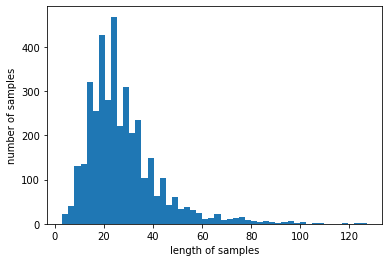

In [13]:
print('최소 길이 :',min(len(w) for w in total))
print('최대 길이 :',max(len(w) for w in total))
print('평균 길이 :',sum(map(len, total))/len(total))
plt.hist([len(w) for w in total], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
total_token_cnt = dict(collections.Counter(total_token))
total_token_cnt

{'지금': 1361,
 '스스로': 13,
 '달라': 167,
 '애원': 2,
 '죽': 161,
 '거': 2156,
 '죽지': 12,
 '사건': 9,
 '휘': 7,
 '말리': 3,
 '해': 704,
 '진짜': 1431,
 '정말': 575,
 '선택': 34,
 '가족': 248,
 '모조리': 4,
 '한번': 383,
 '그냥': 959,
 '이의': 3,
 '제발': 878,
 '길동': 126,
 '경찰서': 23,
 '마트': 4,
 '폭발물': 3,
 '설치': 11,
 '똑바로': 153,
 '더': 757,
 '얘기': 241,
 '장난': 239,
 '전화': 84,
 '업무방해죄': 2,
 '해당': 7,
 '판단': 20,
 '꽤': 25,
 '선생님': 219,
 '난': 408,
 '이야기': 97,
 '경고': 19,
 '말': 2495,
 '네네': 47,
 '때문': 254,
 '애가': 74,
 '지우개': 2,
 '가지': 192,
 '애': 561,
 '앞': 356,
 '면박': 1,
 '댁': 13,
 '내': 3784,
 '따님': 14,
 '번': 243,
 '게': 405,
 '확인': 104,
 '경찰': 184,
 '꾸중': 2,
 '마디': 3,
 '구멍': 13,
 '가게': 74,
 '물건': 78,
 '울면': 4,
 '하교': 2,
 '각오': 19,
 '애도': 16,
 '못': 585,
 '니': 1410,
 '교육': 60,
 '차원': 4,
 '보이': 28,
 '아들': 180,
 '보고': 230,
 '반성': 10,
 '남': 107,
 '함부로': 33,
 '민수': 34,
 '남자': 134,
 '제자': 1,
 '러시': 103,
 '콩팥': 10,
 '정도': 187,
 '가요': 156,
 '상황': 82,
 '사진': 151,
 '줄': 536,
 '테': 55,
 '건가': 144,
 '신고': 354,
 '알': 826,
 '최대한': 54,
 '해치': 2,

In [15]:
threshold = 3
total_cnt = len(total_token_cnt)
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in total_token_cnt.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 : 8189
등장 빈도가 2번 이하인 희귀 단어의 수: 4761
단어 집합에서 희귀 단어의 비율: 58.13896690682623
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.637789647908517


## 벡터화

In [16]:
vector_size = int(total_cnt ** 0.25)
print('vector_size', vector_size)
word_to_vector_model = Word2Vec(total, vector_size=vector_size, window=5, min_count=1, sg=1)

vector_size 9


In [17]:
word_to_vector_model.wv.vectors.shape

(8189, 9)

In [18]:
word_to_vector_model.wv.most_similar("협박")

[('칼', 0.9619616270065308),
 ('식', 0.9589036703109741),
 ('문', 0.9545952677726746),
 ('계속', 0.9544128775596619),
 ('증거', 0.9523685574531555),
 ('기전', 0.9486309885978699),
 ('자꾸', 0.947532057762146),
 ('소문', 0.9263764023780823),
 ('이유', 0.9253955483436584),
 ('전화', 0.9199191331863403)]

In [19]:
word_to_vector_model.wv.most_similar("갈취")

[('시장', 0.9982737898826599),
 ('일당', 0.9976243376731873),
 ('판이', 0.9971135854721069),
 ('문자', 0.9970744848251343),
 ('오백만원', 0.9965466856956482),
 ('치자', 0.9965014457702637),
 ('퇴직', 0.9964081645011902),
 ('일시', 0.9963776469230652),
 ('결과', 0.9963170886039734),
 ('진실', 0.9958471655845642)]

In [20]:
word_to_vector_model.wv.most_similar("직장")

[('온', 0.9896684885025024),
 ('능력', 0.986738920211792),
 ('감당', 0.9841660857200623),
 ('밖', 0.9821810722351074),
 ('결정', 0.9819546341896057),
 ('예전', 0.9795529246330261),
 ('일도', 0.9765892028808594),
 ('취소', 0.9764984250068665),
 ('피맛', 0.9750158786773682),
 ('세상', 0.9748150706291199)]

In [21]:
word_to_vector_model.wv.most_similar("괴롭힘")

[('어쩌겠다', 0.9950518012046814),
 ('낙태', 0.9948241710662842),
 ('외국', 0.9948038458824158),
 ('감옥', 0.9932538866996765),
 ('준지', 0.9927393794059753),
 ('왜그러는데', 0.9926708936691284),
 ('모든', 0.9921283721923828),
 ('교실', 0.9913370609283447),
 ('개자식', 0.9910054206848145),
 ('추억', 0.9891942739486694)]

In [22]:
word_to_vector_model.wv['협박']

array([-0.42785576,  0.6761051 ,  2.234477  ,  0.36553615,  0.7248129 ,
       -0.233704  ,  0.58626944,  0.37305728, -0.20692174], dtype=float32)

In [23]:
word_to_vector_model.wv.similarity('가족', '협박')

0.6707324

In [24]:
word_to_vector_model.wv.similarity('가족', '갈취')

0.7453654

In [25]:
word_to_vector_model.wv.similarity('가족', '직장')

0.83549345

In [26]:
word_to_vector_model.wv.similarity('가족', '괴롭힘')

0.787083

In [27]:
fast_text_model = FastText(total, vector_size=vector_size, window=5, min_count=1, sg=1)

In [28]:
fast_text_model.wv['협박']

array([-0.27800953, -0.15539786, -0.14300974,  0.01599872, -0.42453185,
       -0.65479076, -1.383241  ,  1.1617669 , -0.8468888 ], dtype=float32)

In [29]:
fast_text_model.wv.similarity('에라이', '괴롭힘')

0.81844753

In [30]:
fast_text_model.wv.similarity('임신', '협박')

0.7436501

## 편향성

In [31]:
talk = [' '.join(sum(v, [])) for v in total_dict.values()]
talk[0][:100]

'지금 스스로 달라 애원 죽 거 죽지 사건 휘 말리 해 진짜 정말 선택 가족 정말 선택 선택 가족 모조리 선택 한번 그냥 이의 제발 길동 경찰서 마트 폭발물 설치 똑바로 한번 더 얘'

In [32]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(talk)
X.shape

(4, 7547)

In [33]:
print(vectorizer.vocabulary_['입금'])
print(vectorizer.get_feature_names()[5425])

5360
자성


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [34]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]
for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)

attributes = []
for i in range(len(w)):
    print(class_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 30):
        if vectorizer.get_feature_names()[w[i][j][0]] in fast_text_model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            if j < 20:
                print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

협박: 제발, 지금, 진짜, 사람, 그냥, 정말, 새끼, 생각, 가족, 소리, 신고, 이제, 경찰, 한번, 그게, 오늘, 정신, 목숨, 동생, 장기, 
갈취: 진짜, 지금, 그냥, 제발, 오늘, 엄마, 친구, 정말, 그거, 사람, 새끼, 한번, 저번, 생각, 그게, 내일, 신고, 거기, 이제, 달라, 
직장: 대리, 회사, 지금, 오늘, 부장, 과장, 사람, 업무, 자네, 휴가, 생각, 진짜, 말씀, 그냥, 내일, 그게, 커피, 다시, 정말, 상사, 
괴롭힘: 진짜, 그냥, 지금, 사람, 새끼, 고객, 엄마, 친구, 환불, 제발, 손님, 냄새, 얼굴, 생각, 장애인, 오늘, 기분, 그게, 돼지, 소리, 


In [35]:
matrix = [[0 for _ in range(len(class_name))] for _ in range(len(class_name))]

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y) / std_dev

In [36]:
X = np.array([fast_text_model.wv[word] for word in attributes[0]])
Y = np.array([fast_text_model.wv[word] for word in attributes[1]])

for i in range(len(class_name)-1):
    # i + 1로 이미 계산된 값은 하지 않음 - 좌하단이 0
    for j in range(i + 1, len(class_name)):
        A = np.array([fast_text_model.wv[word] for word in attributes[i]])
        B = np.array([fast_text_model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)
        
for i in range(len(class_name) - 1):
    for j in range(i + 1, len(class_name)):
        print(class_name[i], class_name[j],matrix[i][j])

협박 갈취 0.9198577
협박 직장 0.18078606
협박 괴롭힘 0.67410296
갈취 직장 -0.25093207
갈취 괴롭힘 -0.80662984
직장 괴롭힘 -0.0063940687


<AxesSubplot:>

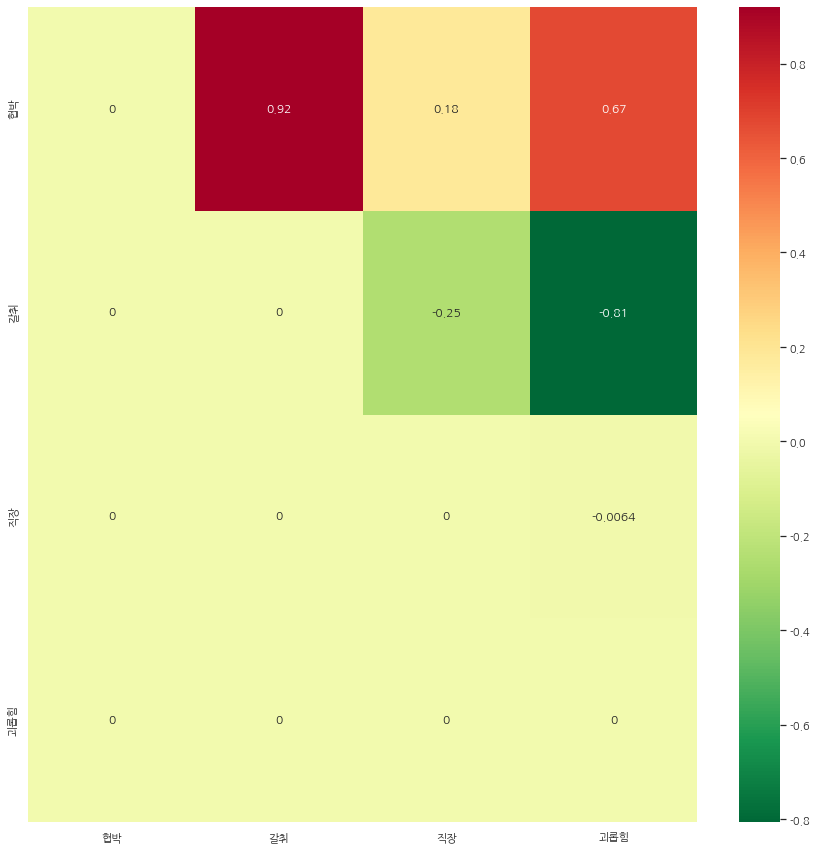

In [37]:
np.random.seed(0)

sns.set(font='NanumGothic')

plt.figure(figsize = (15,15))
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=class_name, yticklabels=class_name, annot=True,  cmap='RdYlGn_r')
ax

In [38]:
# 공통적인 의미를 가진 단어 
common = set(attributes[0]) & set(attributes[1]) & set(attributes[2]) & set(attributes[3])
print(len(common))
common

8


{'그게', '그냥', '사람', '생각', '오늘', '정말', '지금', '진짜'}

In [39]:
clas_name = ['협박', '갈취', '직장', '괴롭힘']
class_dict = {'협박': list(), '갈취': list(), '직장': list(), '괴롭힘': list(), 'class': list()}

def similarity(sen, c_name):
    score = 0
    for s in sen:
        if s in common:
            continue
        score += fast_text_model.wv.similarity(s, c_name)
        
    return score


train_data = train_data.replace({'class': '협박 대화'}, 0)
train_data = train_data.replace({'class': '갈취 대화'}, 1)
train_data = train_data.replace({'class': '직장 내 괴롭힘 대화'}, 2)
train_data = train_data.replace({'class': '기타 괴롭힘 대화'}, 3)
train_data = train_data.astype({'class': 'int'})
print(len(train_data['class']))
print(train_data['class'].head())

for sen, class_num in zip(total, train_data['class']):
    for c in clas_name:
        class_dict[c].append(similarity(sen, c) / len(sen))
    class_dict['class'].append(class_num)

print(class_dict)

3846
0    0
1    0
2    3
3    1
4    1
Name: class, dtype: int64
{'협박': [0.5883029246330261, 0.7584850125842624, 0.7746232106135442, 0.7518680989742279, 0.7958914240201315, 0.7788172284762065, 0.8378095229466757, 0.7442509356667014, 0.7137524212400118, 0.7373465432460049, 0.726753740509351, 0.7629979957599897, 0.696136736869812, 0.7103331089019775, 0.7796604270115495, 0.6914331592046298, 0.6950374362724168, 0.7078087714410597, 0.7834929269413615, 0.7324791888395945, 0.7899615930186378, 0.6501803554986653, 0.6934932557547965, 0.7644638836383819, 0.7525628575911889, 0.6136151936746412, 0.6223854660987854, 0.7512423087049414, 0.7494115075096488, 0.7418780438601971, 0.7118335240765622, 0.7211937147837418, 0.5961566964785258, 0.6595978960394859, 0.657085370272398, 0.610756989982393, 0.7352148254712423, 0.7398224020004273, 0.6819407120347023, 0.7934971592005562, 0.6274560409433702, 0.6961797177791595, 0.778199577331543, 0.7700275358828631, 0.7408203414895318, 0.7514113247394562, 0.662799167

In [40]:
for k, v in class_dict.items():
    print(k, len(v))

협박 3846
갈취 3846
직장 3846
괴롭힘 3846
class 3846


In [41]:
df = pd.DataFrame(class_dict)
print(len(df))
df.head()

3846


,협박,갈취,직장,괴롭힘,class
0,0.588303,0.697440,0.681929,0.712871,0
1,0.758485,0.897608,0.810731,0.902828,0
2,0.774623,0.890007,0.814148,0.894051,3
3,0.751868,0.815374,0.751982,0.820858,1
4,0.795891,0.891701,0.831877,0.897399,1


In [42]:
print(df['class'].isnull().sum())

0


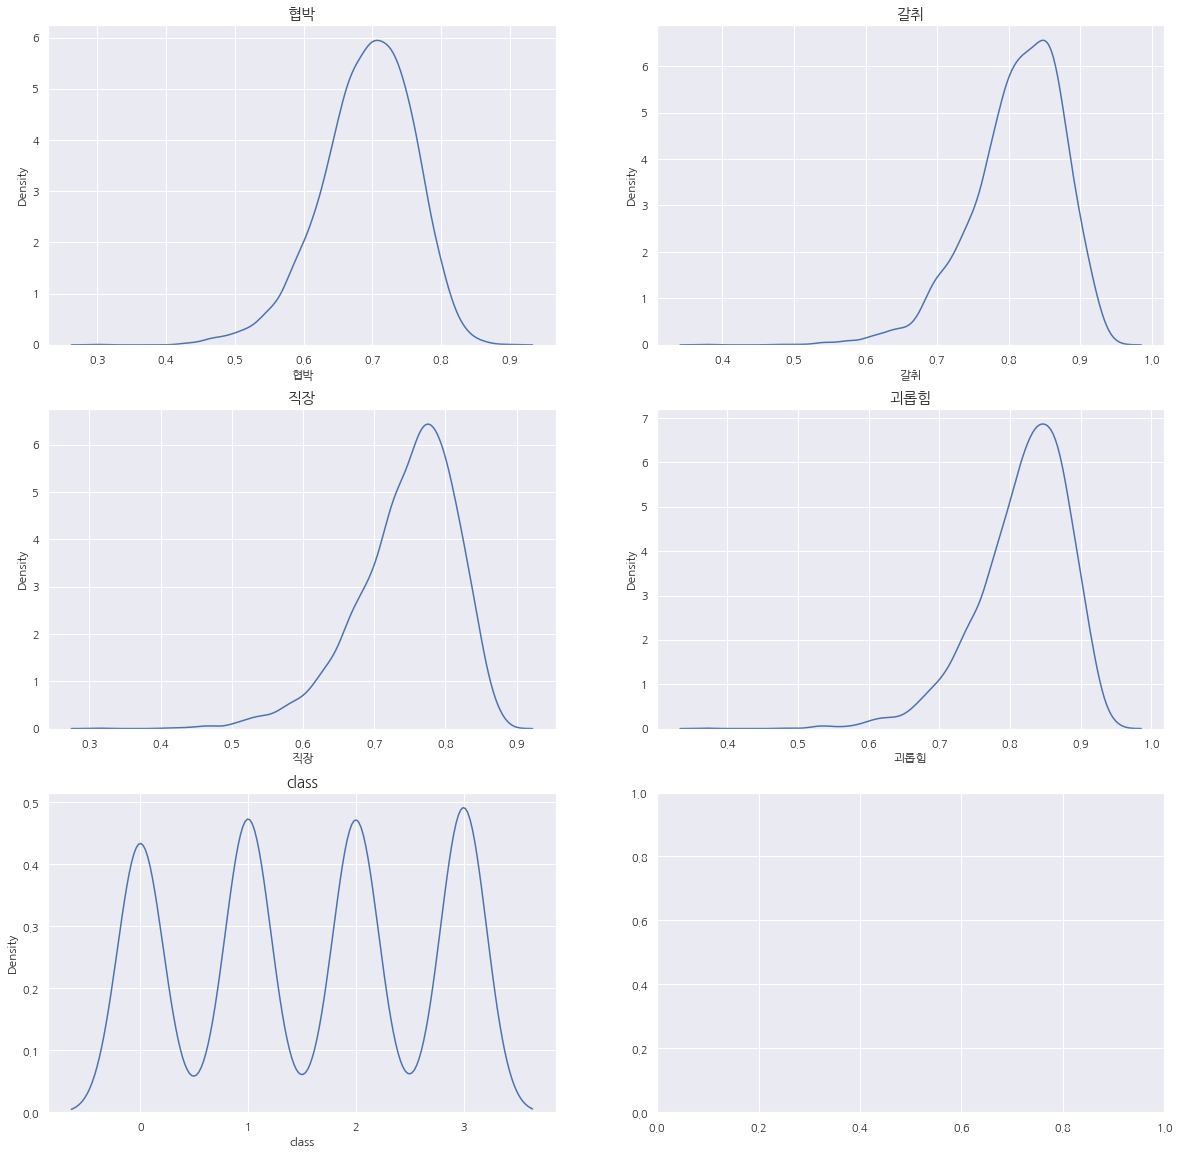

In [43]:
fig, ax = plt.subplots(3, 2, figsize=(20, 20))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = df.columns
for row in range(3):
    for col in range(2):
        sns.kdeplot(df[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 5:
            break

In [44]:
# def mean_norm(df_input):
#     return df_input.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# df[['협박', '갈취', '직장', '괴롭힘']] = mean_norm(df[['협박', '갈취', '직장', '괴롭힘']])
# df.head()

In [45]:
cor_abs = abs(df.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=5, columns = 'class').index
cor = np.array(sp.stats.spearmanr(df[cor_cols].values))[0]
print(cor_cols)
print(df.isnull().sum())
print(cor)

Index(['class', '직장', '협박', '괴롭힘', '갈취'], dtype='object')
협박       0
갈취       0
직장       0
괴롭힘      0
class    0
dtype: int64
[[ 1.          0.01882395 -0.01373038  0.00657309 -0.00422497]
 [ 0.01882395  1.          0.56043056  0.86286086  0.69514145]
 [-0.01373038  0.56043056  1.          0.71907681  0.79054372]
 [ 0.00657309  0.86286086  0.71907681  1.          0.95448505]
 [-0.00422497  0.69514145  0.79054372  0.95448505  1.        ]]


<AxesSubplot:>

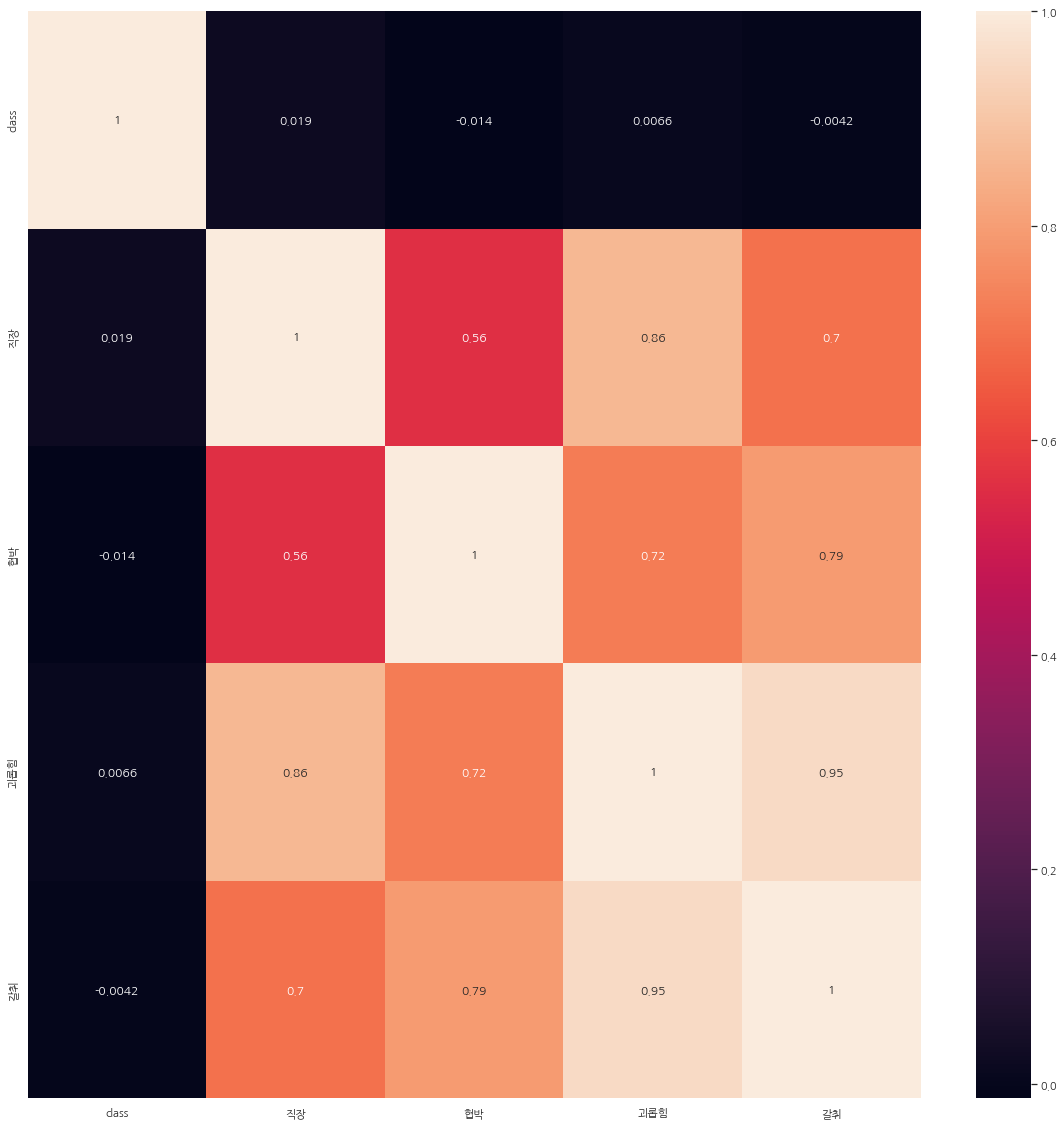

In [46]:
plt.figure(figsize=(20, 20))
sns.heatmap(cor, annot=True, xticklabels=cor_cols.values, yticklabels=cor_cols.values)

In [47]:
class ClassifierModel:
    def __init__(self, model_name):
        self.model_name = model_name
        self.model = None
        
        if self.model_name == 'nb':
            self.model = MultinomialNB()
        
        elif self.model_name == 'cnb':
            self.model = ComplementNB()
        
        elif self.model_name == 'lr':
            self.model = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
        
        elif self.model_name == 'svc':
            self.model = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
        
        elif self.model_name == 'dtc':
            self.model = DecisionTreeClassifier(max_depth=10, random_state=0)
        
        elif self.model_name == 'rfc':
            self.model = RandomForestClassifier(n_estimators=5, random_state=0)
            
        elif self.model_name == 'grc':
            self.model = GradientBoostingClassifier(random_state=0)
            
        elif self.model_name == 'v':
            self.model = VotingClassifier(estimators=[
                ('lr', LogisticRegression(C=10000, penalty='l2')),
                ('cb', ComplementNB()),
                ('grbt', GradientBoostingClassifier(random_state=0)),
                ('rf', RandomForestClassifier(n_estimators=5, random_state=0))
            ], voting='soft', n_jobs=-1)

        self.predicted = None
        self.y_test = None
        
    def fit(self, x, y):
        print('학습 시작', self.model_name)
        self.model.fit(x, y)
    
    def test(self, x, y=None):
        self.predicted = self.model.predict(x)
        
        if y is not None:
            self.y_test = y        
            acc = accuracy_score(y, self.predicted)
            print("정확도:", acc)
            return self.predicted, acc
        
        return self.predicted
    
    def result(self):
        if self.y_test is not None:
            report = classification_report(self.y_test, self.predicted, zero_division=0)
            print(report)
            return report
        return '리포트할 결과가 없습니다'

In [48]:
model_name = ['nb', 'cnb', 'lr', 'svc', 'dtc', 'rfc', 'grc', 'v']

x = df[['협박', '갈취', '직장', '괴롭힘']]
y = df['class']
for m in model_name:
    model = ClassifierModel(m)
    model.fit(x, y)
    model.test(x, y=y)
    model.result()
    joblib.dump(model, f'word2ver_machine_learing_model/{m}.joblib')
    print('-----------------------')

학습 시작 nb
정확도: 0.2628705148205928
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       892
           1       0.00      0.00      0.00       973
           2       0.00      0.00      0.00       970
           3       0.26      1.00      0.42      1011

    accuracy                           0.26      3846
   macro avg       0.07      0.25      0.10      3846
weighted avg       0.07      0.26      0.11      3846

-----------------------
학습 시작 cnb
정확도: 0.26443057722308894
              precision    recall  f1-score   support

           0       0.25      0.41      0.31       892
           1       0.27      0.26      0.26       973
           2       0.00      0.00      0.00       970
           3       0.28      0.39      0.33      1011

    accuracy                           0.26      3846
   macro avg       0.20      0.27      0.22      3846
weighted avg       0.20      0.26      0.22      3846

-----------------------
학습 시작 lr
정확도: 

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


정확도: 0.26859074362974517
              precision    recall  f1-score   support

           0       0.29      0.13      0.18       892
           1       0.26      0.34      0.30       973
           2       0.28      0.02      0.04       970
           3       0.27      0.55      0.36      1011

    accuracy                           0.27      3846
   macro avg       0.27      0.26      0.22      3846
weighted avg       0.27      0.27      0.22      3846

-----------------------
학습 시작 dtc
정확도: 0.37285491419656785
              precision    recall  f1-score   support

           0       0.46      0.26      0.34       892
           1       0.73      0.16      0.26       973
           2       0.61      0.18      0.28       970
           3       0.31      0.86      0.45      1011

    accuracy                           0.37      3846
   macro avg       0.53      0.37      0.33      3846
weighted avg       0.53      0.37      0.33      3846

-----------------------
학습 시작 rfc
정확도: 0.91653

In [49]:
test_data_path ="~/aiffel/dktc/data/test.json"
df_test = pd.read_json(test_data_path)
df_test.head()

,t_000,t_001,t_002,t_004,t_005,t_006,t_007,t_009,t_010,t_012,...,t_489,t_490,t_492,t_493,t_494,t_495,t_496,t_497,t_498,t_499
text,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...,그러니까 빨리 말해. 선생님 제발 살려주십시오. 비밀번호 틀릴 때마다 손톱 하나씩...,그 사람 누구냐? 누구말하는거야? 다 알면서 모른척 하지마. 둘다 쏴버리기 전에...,야 저기야 닭꼬치 트럭왔다 응 그러네 그치? 너도 먹고 싶지? 어?나도? 그래 너 ...,야 너 2학년 김민석 맞지? 네 맞는데요. 혹시 누구신가요? 내가 누군지 궁금하면 ...,예전에 네가 나한테 했던 일 기억하지? 너도 당해봐 예전 일이라면 내가 사과할게. ...,김비서 지금 우리애 학교가서 집에다가 좀 데려다 주세요 사장님 그런 개인적인 일은 ...,...,너 어제 집에 바로 안 들어갔지? 어떻게 알았어? 내가 눈이 좋아 왜 묻는건데? 너...,철수야 말 들어야지 싫은데 철밥통 선생아 너 선생님한테 말버릇이 뭐야 야 내가 너말...,동생이쁘다. 나주라 안돼 우리동생건들지마. 왜 안되냐? 좀 달라고 니 목숨값으로 동...,혹시 나 오늘 2만원만 빌려주만 안돼? 응? 안돼. 나도 요즘 맨날 택시타느라 택시...,이봐 네? 누구세요? 입다물고 가진거 다내놔 경찰에 신고할거에요 할 수 있으면 해봐...,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...,엄마 저 그 돈 안해주시면 정말 큰일나요. 이유도 말하지 않고. 몇번째니 경민아....


In [50]:
df_test = df_test.T
df_test.head()

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
t_005,그러니까 빨리 말해. 선생님 제발 살려주십시오. 비밀번호 틀릴 때마다 손톱 하나씩...


In [51]:
df_test['text'] = df_test['text'].apply(tokenizer)
df_test

,text
t_000,"[아가씨, 담배, 지갑, 에이, 버스, 취소, 요, 아가씨, 내, 단골, 담, 알바..."
t_001,"[팀, 팀, 사람, 지씨, 가요, 달, 파견, 승진, 별로, 사람, 가기, 막내, ..."
t_002,"[오늘, 그게, 뭐, 뭘, 제대로, 똑바로, 행실, 맘, 실천, 옆, 동기, 말, ..."
t_004,"[앞, 니, 내, 와이파이, 와이파이, 온, 반말, 주인, 말, 주인, 오냐, 앞,..."
t_005,"[말, 선생님, 제발, 비밀번호, 손톱, 찌, 선생님, 정말, 엄지, 손톱, 진짜,..."
...,...
t_495,"[미나, 휴가, 결제, 리기, 전, 상의, 말, 거, 기억, 보고서, 상의, 안, ..."
t_496,"[교수, 논문, 이름, 논문, 말, 지난, 번, 논문, 그거, 저자, 거, 흠, 게..."
t_497,"[돈좀, 돈, 돈, 지갑, 폼, 진짜, 내, 확인, 제발, 진짜]"
t_498,"[안, 환자, 제대로, 안, 어제, 저녁, 계속, 지금, 과장, 문제, 사람, 약물..."


In [52]:
test_class_dict = {'협박': list(), '갈취': list(), '직장': list(), '괴롭힘': list()}

for sen in df_test['text']:
    for c in clas_name:
        test_class_dict[c].append(similarity(sen, c) / len(sen))
test_df = pd.DataFrame(test_class_dict)
test_df.head()

,협박,갈취,직장,괴롭힘
0,0.705390,0.827904,0.681269,0.810680
1,0.566686,0.713356,0.693502,0.738322
2,0.531380,0.623483,0.599510,0.641034
3,0.800182,0.924215,0.858313,0.936298
4,0.637807,0.755437,0.704762,0.762939


In [55]:
model = joblib.load('word2ver_machine_learing_model/rfc.joblib') 
print(model)
predicted = model.test(test_df)
predicted

array([1, 3, 2, 2, 3, 1, 1, 1, 2, 3, 3, 3, 3, 2, 1, 1, 1, 2, 0, 0, 1, 0,
       3, 3, 0, 2, 1, 2, 0, 3, 1, 0, 3, 1, 3, 2, 0, 2, 2, 2, 2, 0, 3, 1,
       2, 1, 3, 3, 0, 1, 2, 3, 2, 3, 0, 2, 1, 1, 0, 3, 0, 0, 2, 0, 1, 1,
       3, 2, 1, 0, 1, 1, 1, 1, 2, 3, 0, 2, 2, 1, 3, 3, 2, 0, 3, 0, 0, 0,
       1, 1, 2, 0, 2, 0, 3, 1, 0, 3, 3, 1, 1, 3, 2, 0, 1, 2, 1, 0, 0, 3,
       0, 3, 1, 3, 2, 2, 0, 0, 1, 0, 3, 3, 2, 2, 2, 0, 3, 0, 0, 0, 1, 1,
       0, 0, 2, 0, 2, 1, 1, 3, 1, 0, 1, 2, 2, 0, 0, 2, 1, 1, 3, 2, 2, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 3, 0, 0, 3, 2, 0, 0, 0, 0, 1, 2, 3, 0,
       2, 3, 3, 0, 1, 0, 0, 2, 2, 3, 3, 3, 0, 2, 2, 2, 3, 3, 0, 0, 3, 1,
       1, 2, 3, 3, 1, 2, 2, 2, 2, 0, 0, 3, 3, 0, 1, 0, 0, 0, 3, 0, 1, 3,
       3, 0, 0, 3, 1, 3, 1, 0, 2, 1, 1, 2, 1, 3, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 3, 3, 1, 2, 0, 1, 3, 0, 1, 3, 2, 1, 3, 0, 3, 2, 1, 0, 3, 3,
       1, 1, 0, 0, 0, 0, 1, 2, 0, 2, 1, 3, 2, 1, 0, 2, 1, 3, 2, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 3, 0, 3, 2, 3, 1, 2,

In [54]:
predicted_dict = {'file_name': df_test.index, 'class': predicted}
sub = pd.DataFrame(predicted_dict)
sub.to_csv('submission.csv', index=False)